In [1]:
import torch
import torch.nn as nn
batch_size = 16
# Your model's output logits, shape (batch_size, 4)
logits = torch.randn(batch_size, 4)  # Replace with your actual logits
print(f"logit shape {logits.shape}")
# Ground truth labels as class indices, shape (batch_size,)
labels = torch.randint(4, (batch_size,))  # Replace with your actual labels
print(f"logit shape {labels.shape}")
# Define the Cross-Entropy loss function
criterion = nn.CrossEntropyLoss()

# Compute the loss
loss = criterion(logits, labels)
print(loss)
print(f"loss shape {loss.shape}")

logit shape torch.Size([16, 4])
logit shape torch.Size([16])
tensor(1.6600)
loss shape torch.Size([])


In [2]:
predicted_labels = torch.argmax(logits, dim=1)
print(predicted_labels)
print(labels)

tensor([3, 3, 3, 3, 1, 0, 2, 3, 2, 0, 3, 2, 0, 0, 2, 2])
tensor([0, 2, 2, 3, 2, 0, 1, 1, 3, 3, 1, 1, 0, 2, 2, 3])


In [3]:
from sklearn.metrics import f1_score
correct_predictions = (predicted_labels == labels).sum().item()
accuracy = correct_predictions / batch_size
f1 = f1_score(labels, predicted_labels, average='weighted') 
print(accuracy)
print(f1)

0.25
0.21964285714285714


In [4]:
import yaml

# Load the configuration from the YAML file
with open('config/config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)


In [5]:
from models.LSTM import LSTMDecoder
from models.Attention import EncoderLayer
from simple_parsing import ArgumentParser
import torch
import torch.nn
from Vocabulary import Vocabulary
from models.Graph_Model import GNNEncoder
args = config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = GNNEncoder(
    args = args,
    cg_layer = 3,
    tg_layer = 3,
    aggregate_method = "mean", 
    input_feat = 514,
    hidden_size = 128,
    output_size = 128,
)
decoder = LSTMDecoder(
    vocab_size = 119, 
    embed_size = 512, 
    hidden_size = 512,  
    batch_size= args["batch_size"], 
    bi_direction = args["lstm_param"]["bi_direction"],
    device = device,
    dropout = args["lstm_param"]["dropout"],
        num_layers = args["lstm_param"]["num_layers"]
    )


/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: LSTMDecoder.__init__() got an unexpected keyword argument 'vocab_size'

In [6]:
import os

def count_files_in_directory(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count
path = "../../../../../../srv/scratch/bic/peter/Report/Images/train"
count = count_files_in_directory(path)
print(count)
path= "../../../../../../srv/scratch/bic/peter/full-graph-raw/cell_graphs/train"
count = count_files_in_directory(path)
print(count)

2364
2336


In [ ]:
import torch
if torch.cuda.is_available():
    print("CUDA is available! You can use GPU for accelerated computations.")
else:
    print("CUDA is not available. Using CPU for computations.")

In [ ]:
import os
from Vocabulary import Vocabulary
from dataloader import make_dataloader
split = "eval"
loader,_ = make_dataloader(
    batch_size = 2,
    split = split,
    base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
    graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
    vocab_path = "vocab_bladderreport.pkl",
    shuffle=True,
    num_workers=4,
    load_in_ram = True
)
print(f"length data loader for {split} is {len(loader)}")

# for word, idx in loader.dataset.vocab.word2idx.items():
#     print(f"Word: {word}, Index: {idx}")
cg,tg,am,cap_to, label, cap, img = next(iter(loader))
print(img.shape)

In [ ]:
from glob import glob 
all_img = glob(os.path.join("../../../../../../srv/scratch/bic/peter/Report/Images/train","*.png"))
print(len(all_img))
print(all_img[0])


In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
# Load the image using OpenCV
image = Image.open(all_img[0]).convert('RGB')
print(type(image))
print(image.size)

plt.imshow(image)  # OpenCV uses BGR format, so we convert it to RGB for Matplotlib
plt.title("Image")
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
import torchvision
resnet34 = torchvision.models.resnet34(pretrained=True)

In [ ]:
from torchvision import transforms
import torch
preprocess = transforms.Compose([
    transforms.Resize((500, 500)),  # Resize to the desired size
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Apply the preprocessing steps to the image
print(type(image))
input_tensor = preprocess(image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
with torch.no_grad():
    output = resnet34(input_batch)
print(output.shape)

### Example for nn.TransformerDecoder

In [13]:
import torch
import torch.nn as nn

# Define the parameters
d_model = 512  # Model dimension
nhead = 8     # Number of attention heads
num_layers = 6  # Number of decoder layers
dim_feedforward = 2048  # Feedforward dimension

# Create the decoder
dec = nn.TransformerDecoder(
    nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward),
    num_layers,
)

# Input and target sequences
tgt = torch.rand(10, 32, d_model)  # (sequence_length, batch_size, d_model)
memory = torch.rand(1, 32, d_model)  # (sequence_length, batch_size, d_model)

# Output from the decoder
output = dec(tgt, memory)
print(output.shape)

torch.Size([10, 32, 512])


## Transformers


In [3]:
from models.Graph_Model import GNNEncoder
from models.LSTM import LSTMDecoder
from models.GlobalFeatureExtractor import GlobalFeatureExtractor
from models.Classifier import Classifier
from models.Transformer import TransformerDecoder
from models.Attention import EncoderLayer

### Load a data

In [19]:
import os
from dataloader import make_dataloader
from Vocabulary import Vocabulary
split = "train"
loader,dataset = make_dataloader(
    batch_size = 8,
    split = split,
    base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
    graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
    vocab_path = "vocab_bladderreport.pkl",
    shuffle=True,
    num_workers=2,
    load_in_ram = True
)
print(f"length data loader for {split} is {len(loader)}")
cg, tg, assign_mat, caption_tokens, labels, caption, images = next(iter(loader))
print(f"caption token {caption_tokens.shape}")
    # break

length data loader for train is 292
caption token torch.Size([8, 90])


In [21]:
print(labels)


tensor([0, 1, 1, 0, 1, 1, 2, 2])


In [20]:
print(caption_tokens.shape)

torch.Size([8, 90])


### Model Def

In [14]:
args = {
    'gnn_param': {
        'cell_layers': 2,
        'tissue_layers': 2,
        'aggregate_method': 'sum',  # or any other method you prefer
        'hidden_size': 256,
        'output_size': 128,
        'cell_conv_method': "GCN", # GCN, GAT, GraphSage, GIN, PNA
        'tissue_conv_method': "GCN",
    },
    'lstm_param': {
        'size': 128,
        'bi_direction': True,
        'dropout': 0.2,
        'num_layers': 2,
    },
    'global_class_param': {
        'hidden_size': 512,
        'output_size': 128,
        'dropout_rate': 0.1,
    },
    'classifier_param': {
        'hidden_size': 128,
        'num_class': 3,  # adjust according to your task
        'dropout_rate': 0.3,
    },
    'batch_size': 32,  # adjust according to your needs
}
vocab_size = 119
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = DEVICE
# Create Encoder, Attention, Decoder, Global Feature Extractor, and Classifier instances using the args
encoder = GNNEncoder(
    args=args,
    cg_layer=args['gnn_param']['cell_layers'],
    tg_layer=args['gnn_param']['tissue_layers'],
    aggregate_method=args['gnn_param']['aggregate_method'],
    input_feat=514,
    hidden_size=args['gnn_param']['hidden_size'],
    output_size=args['gnn_param']['output_size'],
).to(device)

attention = EncoderLayer(
    d_model=args['gnn_param']['output_size'],
    nhead=4,
    dim_feedforward=1024,
    dropout=0.2
).to(device)

# decoder = TransformerDecoder(
#         vocab_size = vocab_size,
#         d_model = args['gnn_param']['output_size']+args["global_class_param"]["output_size"],
#         nhead = 2, 
#         num_layers = 3, 
#         dim_feedforward=2048, 
#         dropout=0.2
#     ).to(device)

global_feature_extractor = GlobalFeatureExtractor(
    hidden_size=args["global_class_param"]["hidden_size"],
    output_size=args["global_class_param"]["output_size"],
    dropout_rate=args["global_class_param"]["dropout_rate"]
).to(device)

classifier = Classifier(
    graph_output_size=args['gnn_param']['output_size'],
    global_output_size=args["global_class_param"]["output_size"],
    hidden_size=args["classifier_param"]["hidden_size"],
    num_class=args["classifier_param"]["num_class"],
    dropout_rate=args["classifier_param"]["dropout_rate"]
).to(device)

In [15]:
print(encoder.output_size)
print(global_feature_extractor.output_size)
print(classifier.input_size)

128
128
256


In [27]:
features = torch.rand((8,256))
out = classifier(features)
print(out.shape)

a = out.argmax(dim = 1)
print(a)
print(labels)
gt_label = []
pred_label = []
gt_label.extend(labels.tolist())
print(gt_label)
pred_label.extend(a.tolist())

pred_label.extend(labels.tolist())
print(pred_label)

torch.Size([8, 3])
tensor([1, 1, 1, 1, 1, 1, 1, 2])
tensor([0, 1, 1, 0, 1, 1, 2, 2])
[0, 1, 1, 0, 1, 1, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2]


In [7]:
import torch.nn.functional as F
cg = cg.to(DEVICE)
tg = tg.to(DEVICE)
labels = labels.to(DEVICE)
images = images.to(DEVICE)
attention_masks = attention_masks.to(DEVICE)
out = encoder(cg,tg,assign_mat,images) # (batch_size, 1, embedding)
out = F.normalize(out, p=2, dim=1)
print(out.shape)
print(f"min index in graph enc: {torch.min(out)}, max index in tgt: {torch.max(out)}")
global_feat = global_feature_extractor(images)
print(f"min index in global: {torch.min(global_feat)}, max index in tgt: {torch.max(global_feat)}")
print(f"before cat, out {out.shape} global {global_feat.shape}")
merged_feat = torch.cat((out, global_feat), dim=1)

print(merged_feat.shape)
out = merged_feat
# Add debug print statements

print(f"min index in tgt: {torch.min(out)}, max index in tgt: {torch.max(out)}")
print(f"out shape {out.shape} cap tok shape {caption_tokens.shape}")
# out = attention(merged_feat)
lstm_out = decoder(out,caption_tokens)
print(lstm_out.shape)
'''
(sequence_length, batch_size, d_model)
'''


torch.Size([2, 128])
min index in graph enc: -0.2489909678697586, max index in tgt: 0.25518858432769775
min index in global: 0.0, max index in tgt: 2.020029306411743
before cat, out torch.Size([2, 128]) global torch.Size([2, 128])
torch.Size([2, 256])
min index in tgt: -0.2489909678697586, max index in tgt: 2.020029306411743
out shape torch.Size([2, 256]) cap tok shape torch.Size([2, 90])
memory shape torch.Size([2, 256]) tgt shape torch.Size([2, 90])
torch.Size([90, 2, 119])


'\n(sequence_length, batch_size, d_model)\n'

In [10]:
print(lstm_out.shape)
a= torch.argmax(lstm_out,dim=0)
print(a.shape)

torch.Size([90, 2, 119])
torch.Size([2, 119])


## Dealing with Oversampling

In [ ]:
# split = "train"
# _,dataset = make_dataloader(
#     batch_size = 4,
#     split = split,
#     base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
#     graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
#     vocab_path = "vocab_bladderreport.pkl",
#     shuffle=True,
#     num_workers=2,
#     load_in_ram = True
# )
# class_weights = []
# sample_weights = [0]*len(dataset)
# print(f"length dataset is {len(dataset)}")


### WeightRandomSampler

In [29]:
class_count = {
    '0': 0,
    '1': 0,
    '2': 0,
    }

count = 0
class_weight = []
for idx,output in enumerate(dataset):
    _, _, _, _, labels, _, _= output
    if count % 500 == 0 :
        print(count)
    class_count[str(labels)] += 1
    count += 1

print(class_count)
for key,value in class_count.items():
    class_weight.append(1/value)
print(class_weight)
sample_weights = [0]*len(dataset)

for idx, output in enumerate(dataset):
    _, _, _, _, labels, _, _,_= output
    # print(labels.shape)
    class_count[str(labels)] += 1
    sample_weights[idx] = class_weight[labels]
# print(sample_weights)


0
500
1000
1500
2000
{'0': 557, '1': 738, '2': 1041}
[0.0017953321364452424, 0.0013550135501355014, 0.0009606147934678194]


ValueError: not enough values to unpack (expected 8, got 7)

In [31]:

from IPython.utils import io


In [32]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from dataloader import dataset_to_loader
class_weight = [2,1,1]
sampler = WeightedRandomSampler(weights = sample_weights,num_samples = len(dataset),replacement = True)
# print(list(sampler))
with io.capture_output() as captured:
    dl = dataset_to_loader(dataset,batch_size = 8,sampler = sampler, num_workers = 0)
print(len(dl))
dl_count = []

for idx, output in enumerate(dl):
    # print(output)
    # break
    # print(cap.shape)
    # print(lab)
    _, _, _, _, lab, cap, _,_ = output
    print(lab)
    print(cap[0])
    dl_count.extend([i.item() for i in lab])



292


RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)

In [34]:
from collections import Counter
class_distribution = Counter(dl_count)
print(class_distribution)

Counter({1: 797, 2: 773, 0: 766})


## Vocabluary File

In [11]:
# import pickle
# from Vocabulary import Vocabulary

# vocab_file= "vocab_bladderreport.pkl"

# # Load vocabulary from the pickle file
# with open(vocab_file, 'rb') as file:
#     vocab = pickle.load(file)
# # print(vocab)
# # vocab.add_word("<start>")
# # Print all vocabulary items
# print(vocab.print_all_words())
# # print(vocab.word2idx['<start>'])
# # with open(vocab_file, 'wb') as file:
# #     pickle.dump(vocab, file)

# Build a new vocab file

### Relevant Import

In [1]:
import os
import json
import string
import collections
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from Vocabulary import Vocabulary

### Definition

In [2]:

vocab_file = "new_vocab_bladderreport.pkl"
# with open(vocab_file, 'wb') as file:
#     pickle.dump(vocab, file)
base = "../../../../../../srv/scratch/bic/peter/Report"
train_name = "train_annotation.json"
eval_name = "eval_annotation.json"
test_name = "test_annotation.json"
train_path = os.path.join(base,train_name)
eval_path = os.path.join(base,eval_name)
test_path = os.path.join(base,test_name)

In [3]:
print(train_path)

../../../../../../srv/scratch/bic/peter/Report/train_annotation.json


### Function to read the vocab file

In [4]:
'''
Reads the file in form
{'name':{'caption':[],'label':x:int}} ==> []
'''
def read_file(file_path):
    all_cap = []
    # Read the JSON file
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    for key, value_dict in data.items():
        for cap in value_dict['caption']:
            all_cap.append(cap)
    return data,all_cap



In [5]:
train_data,train_caption = read_file(train_path)
eval_data,eval_caption = read_file(eval_path)
test_data,test_caption = read_file(test_path)

In [6]:
print(len(train_caption))
print(len(eval_caption))
print(len(test_caption))

11820
4445
5000


## Build brand new json file then bui.ld vocab file on them

In [8]:
# print(train_data['N2_07_2'])
# i = train_data['N2_07_2']
# for i 

In [9]:
def random_pick():
    random_integers = set()  # Using a set to ensure uniqueness
    while len(random_integers) < 4:
        random_integers.add(random.randint(0, 4))

    return list(random_integers)  # Return the unique integers as a list
random_pick()

NameError: name 'random' is not defined

In [10]:
def process_cap(caption):
    #caption = 'Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information.'
    sentences = caption.split('. ')
    key_words = ['nucleoli', 'pleomorphism', 'nuclei','polarity','mitosis','nuclear','crowding','is','are','of','the','a','in','and','an']
    clean_sentences = []
    for s, sentence in enumerate(sentences):
        # if 'insufficient information' in sentence and s < (len(sentences)-1): 
        #     clean_sentences.append('')
        #     continue
        words = sentence.split()
        # print(words)
        if len(words)>3 and 'insufficient information' not in sentence:
            for _ in range(0,1):
                idx_to_replace = random.randint(0,len(words)-1)
                word_to_replace = words[idx_to_replace]
                if word_to_replace not in key_words:
                    synonyms = get_synonyms(word_to_replace)
                    if synonyms:
                        synonym = random.choice(synonyms)
                        words[idx_to_replace] = synonym
                    sentence = ' '.join(words)
                    break
        if sentence[-1] != '.':
            clean_sentences.append(sentence+'.')
        else:
            clean_sentences.append(sentence)
    clean_sentences[0] = clean_sentences[0].capitalize()
    clean_sentences = ' '.join(clean_sentences) + ''
    return '. '.join([s.capitalize() for s in clean_sentences.split('. ')])
def rewrite_with_syn(old_path,new_path):
    data,_ = read_file(old_path)
    for key, value_dict in data.items():
        # print(value_dict)
        rand = random_pick()
        for i in rand:
            value_dict['caption'][i] = process_cap(value_dict['caption'][i])
    with open(new_path, 'w') as new_json_file:
        json.dump(data, new_json_file)


In [11]:
new_path = "../../../../../../srv/scratch/bic/peter/Report/process_train_annotation.json"
rewrite_with_syn(train_path,new_path)

NameError: name 'random' is not defined

### Build the corresponding new vocab file


In [7]:
import pickle
import nltk
import collections
vocab_file = "new_vocab_bladderreport.pkl"
#vocab = pickle.load(open(vocab_file,'rb'))
# with open(vocab_file, 'wb') as file:
#     pickle.dump(vocab, file)
vocab = Vocabulary()
base = "../../../../../../srv/scratch/bic/peter/Report"
train_name = "train_annotation.json"
eval_name = "eval_annotation.json"
test_name = "test_annotation.json"
train_path = os.path.join(base,train_name)
eval_path = os.path.join(base,eval_name)
test_path = os.path.join(base,test_name)

In [50]:
!../../../../../../srv/scratch/bic/peter/Report

/bin/bash: ../../../../../../srv/scratch/bic/peter/Report: Is a directory


In [56]:
train_data,train_caption = read_file(train_path)
eval_data,eval_caption = read_file(eval_path)
test_data,test_caption = read_file(test_path)

In [8]:
'''
exp: "Mild pleomorphism and cytologic atypia is present. There are no signs of crowding in the nuclei."
output:
['Mild', 'pleomorphism', 'and', 'cytologic', 'atypia', 
'is', 'present', 'There', 'are', 'no', 'signs', 'of', 
'crowding', 'in', 'the', 'nuclei']

'''
def word_list_from_cap(caption):
    # caption_no_punctuation = caption.translate(str.maketrans('', '', '.'))
    # # Split the caption into words
    # words = caption_no_punctuation.lower().split()
    words = nltk.tokenize.word_tokenize(str(caption).lower())
    words = [word for word in words if '.' not in word]
    #words = nltk.word_tokenize(text.lower())

    return words

'''
caption_file_list: list of captioning file to get
threshold_freq: only extract words that appear more than this threshold value times

Aim to build the vocabluary file
'''
def build_vocab(all_caption_list,threshold_freq,vocab,file_path):
    '''
    add
    <start>
    <pad>
    <end>
    ''' 
    vocab.add_word('<start>')
    vocab.add_word('<pad>')
    vocab.add_word('<end>')
    vocab.add_word('<full-stop>')
    vocab.add_word('<unk>')
    
    all_words = []
    num_cap = 0
    for cap_list in all_caption_list:
        for cap in cap_list:
            num_cap += 1
            word_list = word_list_from_cap(cap)
            for word in word_list:
                all_words.append(word)
    # print(all_words)
    print(f"total num of caption: {num_cap}")
    counter = collections.Counter(all_words)
    freq_map = dict(counter) # get words frequency
    print(f"total word is {len(freq_map)}")
    # print(freq_map)
    for word,freq in  freq_map.items():
        if freq < threshold_freq:
            #print(f"word {word}: freq = {freq}")
            continue
        vocab.add_word(word)
    print(len(vocab))
    with open(file_path, 'wb') as f:
        pickle.dump(vocab, f)
    return vocab, freq_map

Total number of caption: **21265** \
Total number of word in all three captioning file is: **127** \
Least appeared word is **appear**: **181** times in total. \
Training caption number: **127**  \
Thus it covers all words

In [9]:
'''
least appeared word is appear:  train_caption, eval_caption, test_caption

only train 24613: is
all caption
'''
vocab,freq_map = build_vocab([train_caption, eval_caption, test_caption],50,vocab,vocab_file)

total num of caption: 21265
total word is 112
117


In [74]:
!ls

 config		       GNN_trial.o5226154     new_vocab_bladderreport.pkl
'#dataloader.py#'      GNN_trial.o5226466     process_vocab_bladderreport.pkl
 dataloader.py	       GNN_trial.o5227153     __pycache__
 data_plotting.py      GNN_trial.o5227522     requirements.txt
 data_view.ipynb       GNN_trial.o5228038     sent_utils
 dgl-workspace.ipynb   graph.dgl	      split_data.py
 eval.py	       graph_generation.py    target_img
 evaluation.py	       graph_gen_job.pbs      text_check.ipynb
 GCN-LSTM-40eps.png    GS-LSTM-40eps.png      train_classifier.py
 GNN_trial.e5226108    inference_CLIP.ipynb   train_clip.py
 GNN_trial.e5226154    inference_img	      train.py
 GNN_trial.e5226466    inference.ipynb	      trial.py
 GNN_trial.e5227153    job.pbs		      Untitled.ipynb
 GNN_trial.e5227522    k_fold_train.py	      vocab_bladderreport.pkl
 GNN_trial.e5228038    model_building.py      Vocabulary.py
 GNN_trial.o5226108    models		      wandb


In [11]:
vocab_file = "new_vocab_bladderreport.pkl"
vocab = pickle.load(open(vocab_file,'rb'))
vocab.print_all_words()

key 0: <start>
key 1: <pad>
key 2: <end>
key 3: <full-stop>
key 4: <unk>
key 5: mild
key 6: pleomorphism
key 7: is
key 8: present
key 9: there
key 10: are
key 11: no
key 12: signs
key 13: of
key 14: crowding
key 15: in
key 16: the
key 17: nuclei
key 18: polarity
key 19: along
key 20: basement
key 21: membrane
key 22: negligibly
key 23: lost
key 24: mitosis
key 25: rare
key 26: have
key 27: inconspicuous
key 28: nucleoli
key 29: normal
key 30: nuclear
key 31: features
key 32: show
key 33: pictured
key 34: exhibit
key 35: not
key 36: exceedingly
key 37: and
key 38: limited
key 39: only
key 40: to
key 41: basal
key 42: layer
key 43: urothelium
key 44: retain
key 45: a
key 46: cytologic
key 47: atypia
key 48: appears
key 49: be
key 50: absent
key 51: slight
key 52: variability
key 53: size
key 54: shape
key 55: outline
key 56: ,
key 57: consistent
key 58: with
key 59: normally
key 60: crowded
key 61: completely
key 62: toward
key 63: surface
key 64: visible
key 65: prominent
key 66: observ

35128
dict_keys(['the', 'is', 'of', 'and', 'are', 'pleomorphism', 'nucleoli', 'nuclei', 'grade', 'mitosis', 'polarity', 'to', 'nuclear', 'rare', 'mild', 'insufficient', 'information', 'crowding', 'urothelium', 'high', 'there', 'moderate', 'prominent', 'comprise', 'low', 'in', 'degree', 'present', 'a', 'be'])


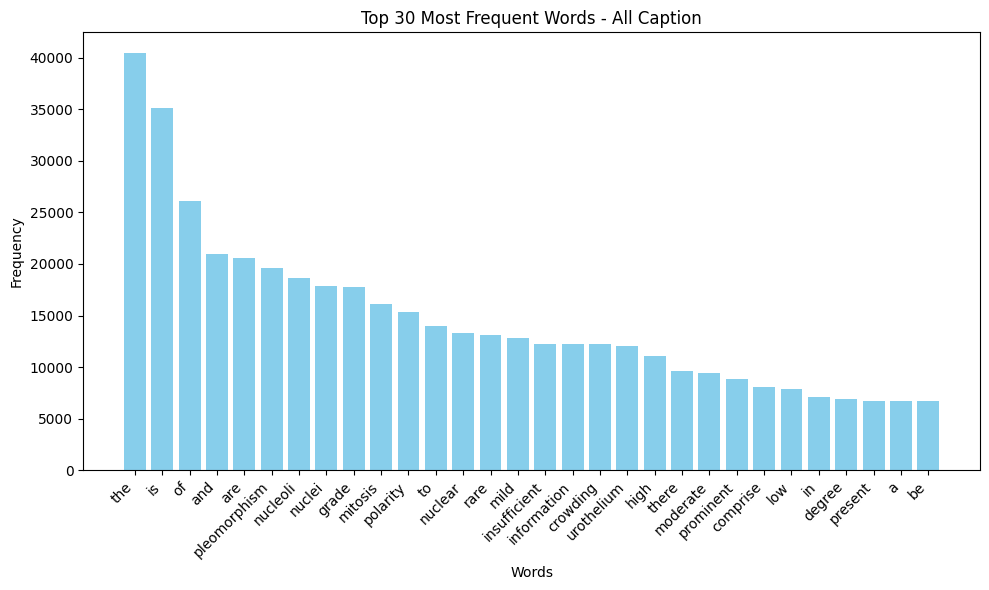

"\n'nucleoli', 'pleomorphism', 'nuclei','polarity','mitosis','nuclear','crowding'\n"

In [346]:
print(freq_map["is"])
# Sort the dictionary by values to get the most frequent words
sorted_words = sorted(freq_map.items(), key=lambda x: x[1], reverse=True)

# Select top 20 most frequent words for plotting
top_words = dict(sorted_words[:30])
print(top_words.keys())
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values(), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Words - All Caption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
'''
'nucleoli', 'pleomorphism', 'nuclei','polarity','mitosis','nuclear','crowding'
'''

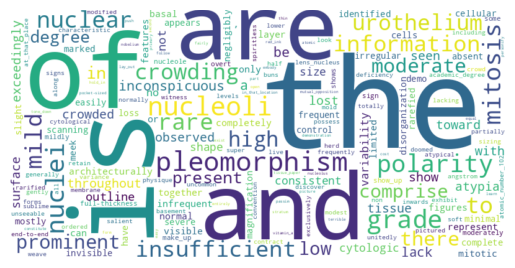

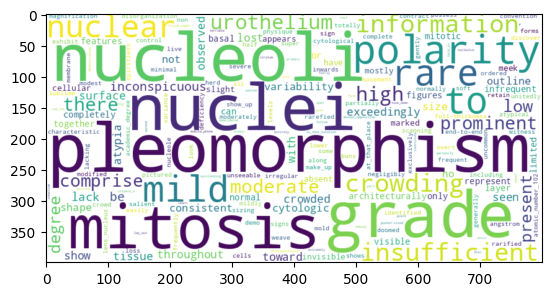

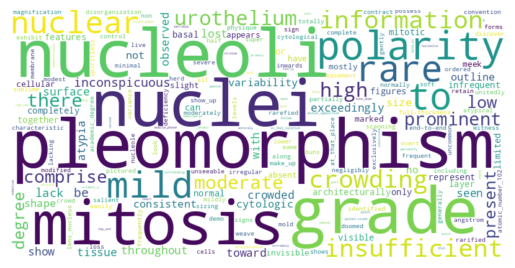

In [339]:
# text = " ".join([(k + " ")*v for k,v in freq_map.items()])

# # Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(freq_map)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
clean_freq_map = freq_map.copy()
keys_to_remove = ['is','are','of','the','a','in','and']
for key in keys_to_remove:
    if key in clean_freq_map:
        del clean_freq_map[key]


# lower max_font_size
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(clean_freq_map)
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



### Write to a pkl file

In [347]:
import pickle
vocab_file= "process_vocab_bladderreport.pkl"
with open(vocab_file, 'wb') as file:
    pickle.dump(vocab, file)

### Load it and read it

In [47]:
import pickle
vocab_file= "new_vocab_bladderreport.pkl"

# Load vocabulary from the pickle file
with open(vocab_file, 'rb') as file:
    vocabs = pickle.load(file)
print(len(vocabs))
vocab_size = len(vocabs)

115


In [191]:
embed = torch.tensor([ 0, 33, 79, 89, 88, 19, 62, 92, 98, 19, 18, 48, 98, 19, 62,  5, 65, 23,
        88,  5,  5, 65, 95, 65, 26, 89, 92, 89, 79, 89, 79, 95, 65, 95, 54, 89,
        79, 49, 79, 89, 79, 49, 79, 95, 65,  0, 65,  5, 96, 80])

In [197]:
sentence = " ".join([vocabs.idx2word[int(idx)] for idx in embed])

sentence = sentence.replace("<pad>","").replace("<start>","")
sentence = ' '.join(sentence.split()).replace("<end>", ".")
print(sentence)

not appear low identified membrane visible cells all membrane basement absent all membrane visible is or rare identified is is or atypical or nucleoli low cells low appear low appear atypical or atypical , low appear slight appear low appear slight appear atypical or or is forms moderate


## Dataset Show

In [3]:
!ls ../../../../../../srv/scratch/bic/peter/Report/Images

eval  test  train


In [4]:
import os
import json
image_base = "../../../../../../srv/scratch/bic/peter/Report/Images"
img_split = "train"
train_img_dir = os.path.join(image_base,img_split)
base = "../../../../../../srv/scratch/bic/peter/Report"
train_name = "train_annotation.json"
train_cap_path = os.path.join(base,train_name)

In [5]:
with open(train_cap_path, 'r') as json_file:
    train_data = json.load(json_file)
    # print(data)
test_name = "test_annotation.json"


In [6]:
# !ls ../../../../../../srv/scratch/bic/peter/Report/Images/train

2364
Full filename: 2_00079_sub0_022.png
Filename without extension: 2_00079_sub0_022
['Mild pleomorphism and cytologic atypia is present. Nuclei are moderately crowded together. insufficient information. Mitosis is rare throughout the tissue. The nuclei have inconspicuous nucleoli. Low grade.', 'Slight variability in nuclear size shape and outline, consistent with mild pleomorphism. The nuclei are crowded to a moderate degree. insufficient information. Mitosis is rare. The nuclei have inconspicuous nucleoli. Low grade.', 'Nuclear features show mild pleomorphism. Nuclei are moderately crowded together. insufficient information. Mitosis is rare throughout the tissue. The nucleoli are mostly inconspicuous. Low grade.', 'Nuclear features show mild pleomorphism. Moderate nuclear crowding is seen. insufficient information. Mitosis is rare. Nucleoli is absent to inconspicuous. Low grade.', 'Slight variability in nuclear size shape and outline, consistent with mild pleomorphism. The nuclei ar

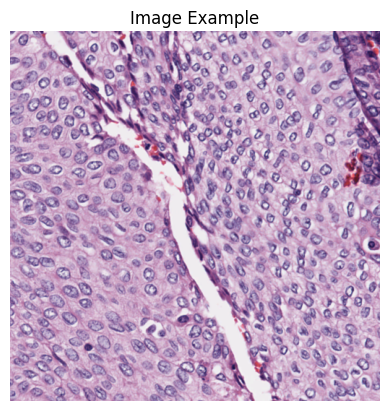

In [18]:
import glob
import random
import cv2
import matplotlib.pyplot as plt


all_files = glob.glob(train_img_dir + '/*.png')
print(len(all_files))

def find_one(all_files):
    length = len(all_files)
    idx = random.randint(0,length)
    img_name = all_files[idx]
    directory, full_filename = os.path.split(img_name)
    filename, extension = os.path.splitext(full_filename)
    
    print("Full filename:", full_filename)
    print("Filename without extension:", filename)
    return img_name, filename

img_path, pure_name = find_one(all_files)
# img_path = "../../../../../../srv/scratch/bic/peter/Report/Images/train/118345_012.png"
# pure_name = "118345_012"
caption = train_data[pure_name]['caption']
print(caption)

# Open the image file
image = cv2.imread(img_path)
# dir_name, img_name = os.path.split(image_path)
# # Convert the BGR image to RGB (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(image_rgb)
plt.title("Image Example")
plt.axis('off')  # Hide the axis
plt.show()

In [57]:
caption = 'Mild pleomorphism and cytologic atypia is present. Nuclei are moderately crowded together. insufficient information. Mitosis is rare throughout the tissue. The nuclei have inconspicuous nucleoli. High Grade.'
caption = 'Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information.'
sentences = caption.lower().rstrip('.').replace(',','').split('. ')
caption_tokens = [] # convert to tokens for all num_feature sentences
clean_sentences = []
for s, sentence in enumerate(sentences[:-1]):
    if 'insufficient information' in sentence and s < (len(sentences)-1): 
        clean_sentences.append('')
        continue
    clean_sentences.append(sentence + ' <end>')
print(clean_sentences)
clean_sentences = ' '.join(clean_sentences) + ''

if clean_sentences.isspace():
    clean_sentences = "<end>"
print(caption)
print("----")
print(clean_sentences)

['', '', '', '', '']
Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information. Insufficient Information.
----
<end>


## Generate and Visualise Graph

In [23]:
import sys
import numpy as np
from PIL import Image
sys.path.append('../histocartography/histocartography')
sys.path.append('../histocartography')
from histocartography.preprocessing import NucleiExtractor, DeepFeatureExtractor, KNNGraphBuilder, RAGGraphBuilder, ColorMergedSuperpixelExtractor
nuclei_detector = NucleiExtractor()
tissue_detector = ColorMergedSuperpixelExtractor(
    superpixel_size=500,
    compactness=30,
    blur_kernel_size=1,
    threshold=0.05,
    downsampling_factor=4
)
tissue_feature_extractor = DeepFeatureExtractor(
            architecture='resnet34',
            patch_size=144,
            resize_size=224
        )
rag_graph_builder = RAGGraphBuilder(add_loc_feats=True)
feature_extractor = DeepFeatureExtractor(architecture='resnet34', patch_size=72)
knn_graph_builder = KNNGraphBuilder(k=3, thresh=70, add_loc_feats=True)
image = np.array(Image.open(img_path))
nuclei_map, _ = nuclei_detector.process(image)
features = feature_extractor.process(image, nuclei_map)
cell_graph = knn_graph_builder.process(nuclei_map, features)

UnpicklingError: invalid load key, '\x0a'.

In [ ]:
from histocartography.visualization import OverlayGraphVisualization, InstanceImageVisualization

visualizer = OverlayGraphVisualization(
    instance_visualizer=InstanceImageVisualization(
    instance_style="filled+outline"
    )
)
viz_cg = visualizer.process(
     canvas=image,
     graph=cell_graph,
     instance_map=nuclei_map
 )

viz_cg.show()

In [ ]:
visualizer = OverlayGraphVisualization(
    instance_visualizer=InstanceImageVisualization(
    instance_style="filled+outline"
    )
)
viz_tg = visualizer.process(
     canvas=image,
     graph=tissue_graph,
     instance_map=superpixels
 )

viz_tg.show()

## Show the one generated

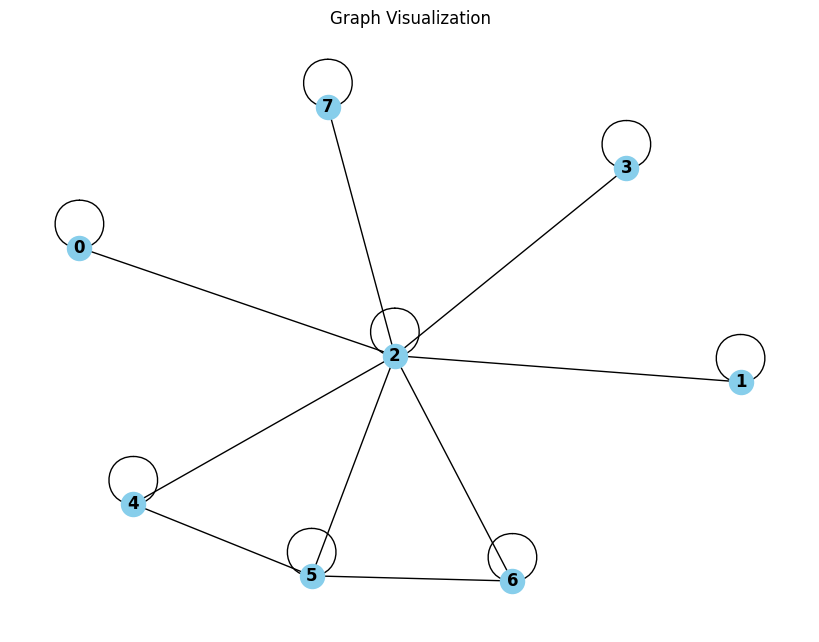

In [34]:
import networkx as nx
import dgl
graph_path = "../../../../../../srv/scratch/bic/peter/full-graph/tissue_graphs/train/118345_012.bin"
graph = dgl.load_graphs(graph_path)[0][0]  # Assuming there's only one graph per file
# Convert DGL graph to NetworkX graph
nx_graph = graph.to_networkx().to_undirected()  # Convert to NetworkX graph

# Plotting the NetworkX graph
plt.figure(figsize=(8, 6))
nx.draw(nx_graph, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold')
plt.title('Graph Visualization')
plt.show()


## Inference

In [1]:
import sys
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import random
import torchvision.transforms as transforms
import dgl
import ssl
import os
import h5py
import networkx as nx
from dataloader import make_dataloader,dataset_to_loader
from PIL import Image
from graph_generation import GraphBuilding
from Vocabulary import Vocabulary
ssl._create_default_https_context = ssl._create_unverified_context # Use it to solve SSL 

[nltk_data] Downloading package wordnet to /home/z5313504/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import os
import json
eval_name = "eval_annotation.json"
base = "../../../../../../srv/scratch/bic/peter/Report"
eval_cap_path = os.path.join(base,eval_name)
print(eval_cap_path)
with open(eval_cap_path, 'r') as json_file:
    eval_data = json.load(json_file)
print(len(eval_data.keys()))

train_name = "train_annotation.json"
base = "../../../../../../srv/scratch/bic/peter/Report"
train_cap_path = os.path.join(base,train_name)
print(train_cap_path)
with open(train_cap_path, 'r') as json_file:
    train_data = json.load(json_file)
print(len(train_data.keys()))

test_name = "test_annotation.json"
base = "../../../../../../srv/scratch/bic/peter/Report"
test_cap_path = os.path.join(base,test_name)
print(test_cap_path)
with open(test_cap_path, 'r') as json_file:
    test_data = json.load(json_file)
print(len(test_data.keys()))

import pickle
vocab_file= "new_vocab_bladderreport.pkl"

# Load vocabulary from the pickle file
with open(vocab_file, 'rb') as file:
    vocabs = pickle.load(file)
print(len(vocabs))
vocab_size = len(vocabs)

../../../../../../srv/scratch/bic/peter/Report/eval_annotation.json
889
../../../../../../srv/scratch/bic/peter/Report/train_annotation.json
2364
../../../../../../srv/scratch/bic/peter/Report/test_annotation.json
1000
117


In [3]:
'''
label1: LP11_12_7  H3_01_1  1_00156_sub0_003  235
label2: 115831_009  118230_000  115831_010  115853_001 1_00156_sub0_055

label3: 1_00161_sub0_007     116974_002   LP8_68_1 71 LP8_59_8 '2_00377_sub0_026

''' 

eval_key = eval_data.keys()
test_key = test_data.keys()
eval_set = random.sample(eval_key, 10)
print(eval_set)
# print([key for key,value in eval_data.items() if value['label'] == 2])
#print(len([key for key,value in eval_data.items() if value['label'] == 3]))

['116933_010', '115934_014', '116700_010', 'H3_03_3', '118367_007', '118421_005', '116745_003', '115951_012', 'LP11_11_4', '118367_014']


/scratch/pbs.5267136.kman.restech.unsw.edu.au/ipykernel_3251551/2852097467.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  eval_set = random.sample(eval_key, 10)


In [4]:
def embed2sentence(decode_output, loader, captions, pred_dict, cap_dict):

    for i,caption in enumerate(captions):
        for sent_i,sent_cap in enumerate(caption):
            captions[i][sent_i] = ' '.join(sent_cap.split()).replace("<pad>", "").replace("<end>", ".").replace("<start>","").replace('<unk>',"")
            
    j = 0
    for idx,embed in enumerate(decode_output):

        sentence = " ".join([loader.dataset.vocab.idx2word[int(idx)] for idx in embed])
        sentence = sentence.replace("<pad>","").replace("<start>","")
        sentence = ' '.join(sentence.split()).replace("<end>", ".")
        #print(f"length pred_dict {len(pred_dict.keys())} and length cap {len(cap_dict.keys())}")
        if len(pred_dict.keys()) == 0:
            #   Empty
            pred_dict["1"] = [sentence]
            print(f"at 0, sentence is {sentence} decode is {embed}")
            # for i in range(5):
            #     cap_dict[str(int(i)+1)] = captions[idx]
            cap_dict["1"] = captions[idx]

            pass
        else:
            pred_dict[str(len(pred_dict)+1)] = [sentence]
            cap_dict[str(len(cap_dict)+1)] = captions[idx]
    
    return pred_dict,cap_dict

In [5]:
def get_all_models(model_base_path,encoder_name,global_extractor_name,decoder_name,device): 
    # current_directory = os.getcwd()

    encoder_path = os.path.join(model_base_path,encoder_name)
    global_feat_path = os.path.join(model_base_path,global_extractor_name)
    decoder_path = os.path.join(model_base_path,decoder_name)
    if os.path.exists(encoder_path):
        # load
        print(f"encoder exists at {encoder_path}")
        encoder = torch.load(encoder_path, map_location=torch.device('cpu')).to(device)
        encoder.eval()
        pass
    else:
        raise Exception(f"Encoder path {encoder_path} not exist")
    
    if os.path.exists(global_feat_path):
        # load
        print(f"global exsists at {global_feat_path}")
        global_feat_extractor = torch.load(global_feat_path, map_location=torch.device('cpu')).to(device)
        global_feat_extractor.eval()
        pass
    else:
        raise Exception(f"Encoder path {encoder_path} not exist")

    if os.path.exists(decoder_path):
        # load
        print(f"decoder exists at {decoder_path}")
        decoder = torch.load(decoder_path, map_location=torch.device('cpu')).to(device)
        decoder.eval()
    else:
        raise Exception(f"Encoder path {decoder_path} not exist")
    return encoder,global_feat_extractor,decoder

In [6]:
def beam_search(merged_feat,decoder,beam_size,vocab):
    # merged_feat (batch_size,embed_size)
    k = beam_size
    
    batch_size = merged_feat.shape[0]
    embed_size = merged_feat.shape[1]
    merged_feat = merged_feat.unsqueeze(0)
    merge_feat = merged_feat.expand(k,batch_size,embed_size)
    
     # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor(vocab.word2idx['<start>'] * k).to(device)  # (k, 1)
    
     # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words
    
    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Lists to store completed sequences and scores
    complete_seqs = list()
    complete_seqs_scores = list()
    
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)


In [7]:
def greedy_decode_trans(features,max_length,decoder):
    start_token = 0
    batch_size = features.size(0)
    #features = self.feature_projection(features)
    features = features.unsqueeze(1)  # Add sequence dimension
    input_ids = torch.full((batch_size, 1), fill_value=start_token , dtype=torch.int64).to(decoder.device)

    #print(f"input id shatart {input_ids[:, -max_length:]}")
    
    logits_tensor = torch.zeros((batch_size, max_length, decoder.vocab_size)).to(decoder.device)
    final_output = torch.zeros(batch_size, max_length, dtype=torch.int64).to(decoder.device)
    final_output[:,0] = 0 # starting token
    for i in range(max_length - 1):
        input_embeddings = decoder.embedding(input_ids)
        tgt_mask = decoder.generate_tgt_mask(i+1).to(decoder.device)
        input_embeddings = decoder.positional_encoding(input_embeddings)
        print(tgt_mask)
        decoder_output = decoder.transformer_decoder(input_embeddings, features,tgt_mask = tgt_mask)
        #print(decoder_output.shape)
        next_token_logits = decoder.fc_out(decoder_output[:,-1,:])
        logits_tensor[:,i,:] = next_token_logits
        score,next_token = torch.max(next_token_logits,dim = 1)
        input_ids = torch.cat([input_ids,torch.ones(1, 1).type_as(input_ids.data).fill_(next_token.item())], dim=1)
        #input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)
        print(f"next tok is {next_token} input ids {input_ids}")
    return input_ids,logits_tensor

In [46]:
def decode_lstm(features,max_length,decoder):
    decoder.eval()
    start_token = 0
    inputs = features
    inputs = inputs.unsqueeze(1) 
    batch_size = inputs.shape[0]  
    final_output = torch.zeros(batch_size, max_length, dtype=torch.long).to(decoder.device)       
    hidden = decoder.init_hidden(inputs,batch_size)
    final_output[:,0] = start_token
    # print(final_output[0])
    outputs_tensor = torch.zeros((batch_size, max_length, decoder.vocab_size)).to(decoder.device)
    outputs_tensor[:,0,start_token] = 1

    for idx in range(max_length-1):
        #print(f"curr index is {idx}")
        lstm_out, hidden = decoder.lstm(inputs, hidden) 
        #outputs = self.linear(self.dropout(lstm_out))
        outputs = decoder.dropout(decoder.linear(lstm_out ))
        # print(f"outputs after linear is {outputs.shape}")
        outputs = outputs.squeeze(1) 
        outputs_tensor[:,idx+1,:] = outputs


        _, max_idx = torch.max(outputs, dim=1) 
        # if torch.all(max_idx == self.end_token):
        #     break

        final_output[:,idx+1] = max_idx
        if (idx >= max_length ):
            break

        inputs = decoder.word_embedding(max_idx) 

        #inputs = self.word_embedding(final_output[:,:idx+1])[:,-1,:]
        #print(f"inputs after emb {inputs.shape}")
        inputs = inputs.unsqueeze(1)  
    return final_output,outputs_tensor

In [47]:
def inference(encoder, global_feat_extractor, decoder, image_path,  cg_path,tg_path,assign_mat_path, vocab, device):
    def h5_to_tensor(h5_path):
        h5_object = h5py.File(h5_path, 'r')
        out = torch.from_numpy(np.array(h5_object['assignment_matrix']))
        return out
    # get image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
         transforms.Resize(299),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
    ])
    # get cg
    cg = dgl.load_graphs(cg_path)[0][0].to(device)
    #get tg
    tg = dgl.load_graphs(tg_path)[0][0].to(device)


    #get assign_mat
    assign_mat = h5_to_tensor(assign_mat_path).float().to(device)
    # print(assign_mat.shape)

    # Apply the transformation to the image
    image = torch.stack([transform(image)]).to(device)
    out = encoder(cg,tg,[assign_mat],image)
    #print(out[:, :10])

    global_feat = global_feat_extractor(image)
   # print(global_feat[:,:10])
    #merged_feat = global_feat
    # #print(merged_feat.shape)
    merged_feat = torch.cat((out, global_feat), dim=1)
    #merged_feat = out
    # lstm_out, lstm_ten= decoder.predict(merged_feat,70)
    #lstm_out, lstm_ten= greedy_decode_trans(merged_feat,70,decoder)
    lstm_out, lstm_ten= decode_lstm(merged_feat,70,decoder)
    print(lstm_out)
    sentence = " ".join([vocab.idx2word[int(idx)] for idx in lstm_out.squeeze()])
    sentence = sentence.replace("<pad>","").replace("<start>","")
    sentence = ' '.join(sentence.split()).replace("<end>", ".").replace("<full-stop>",".")
    return sentence

In [73]:
!ls 

 config		       GNN_trial.o5226154     new_vocab_bladderreport.pkl
'#dataloader.py#'      GNN_trial.o5226466     process_vocab_bladderreport.pkl
 dataloader.py	       GNN_trial.o5227153     __pycache__
 data_plotting.py      GNN_trial.o5227522     requirements.txt
 data_view.ipynb       GNN_trial.o5228038     sent_utils
 dgl-workspace.ipynb   graph.dgl	      split_data.py
 eval.py	       graph_generation.py    target_img
 evaluation.py	       graph_gen_job.pbs      text_check.ipynb
 GCN-LSTM-40eps.png    GS-LSTM-40eps.png      train_classifier.py
 GNN_trial.e5226108    inference_CLIP.ipynb   train_clip.py
 GNN_trial.e5226154    inference_img	      train.py
 GNN_trial.e5226466    inference.ipynb	      trial.py
 GNN_trial.e5227153    job.pbs		      Untitled.ipynb
 GNN_trial.e5227522    k_fold_train.py	      vocab_bladderreport.pkl
 GNN_trial.e5228038    model_building.py      Vocabulary.py
 GNN_trial.o5226108    models		      wandb


In [41]:
#!ls ../../../../../../srv/scratch/bic/peter/model_save/*Decoder-16-*.pt | xargs -n 1 basename

In [69]:
'''
new_vocab_bladderreport.pkl
process_vocab_bladderreport.pkl
vocab_bladderreport.pkl
'''
import torch
encoder_name  = "Encoder-16-130-2.91.pt"
global_extractor_name = "GlobalExtractor-16-130-2.91.pt"
decoder_name = "Decoder-16-130-2.91.pt"
model_base_path = "../../../../../../srv/scratch/bic/peter/model_save"
device = "cpu"
encoder, global_feature_extractor, decoder =  get_all_models(model_base_path,encoder_name,global_extractor_name,decoder_name,device)
print(decoder)

encoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Encoder-16-130-2.91.pt
global exsists at ../../../../../../srv/scratch/bic/peter/model_save/GlobalExtractor-16-130-2.91.pt
decoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Decoder-16-130-2.91.pt
LSTMDecoder(
  (dropout): Dropout(p=0.4, inplace=False)
  (word_embedding): Embedding(115, 512)
  (attention): BahdanauAttention(
    (W_a): Linear(in_features=512, out_features=128, bias=True)
    (U_a): Linear(in_features=128, out_features=128, bias=True)
    (v_a): Linear(in_features=128, out_features=1, bias=True)
  )
  (lstm): LSTM(512, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=115, bias=True)
  (init_h): Linear(in_features=512, out_features=128, bias=True)
  (init_c): Linear(in_features=512, out_features=128, bias=True)
)


In [48]:
def is_distinct(lst):
    return len(lst) == len(set(lst))
import random
name = "2_00377_sub0_024"
name_list = [
            # 'LP11_12_7','H3_01_1',
            # '115831_009','115831_010',
             '1_00161_sub0_007'
            ]

name_list = random.sample(test_key, 2)
# name_list = list(test_key)
vocab_file= "new_vocab_bladderreport.pkl"
print(f"is distinct {is_distinct(name_list)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_name  = "Encoder-16-130-2.91.pt"
global_extractor_name = "GlobalExtractor-16-130-2.91.pt"
decoder_name = "Decoder-16-130-2.91.pt"
model_base_path = "../../../../../../srv/scratch/bic/peter/model_save"
# device = "cpu"
encoder, global_feature_extractor, decoder =  get_all_models(model_base_path,encoder_name,global_extractor_name,decoder_name,device)
print(decoder)
sentence_dict = {}
for name in name_list:
    image_path = f"../../../../../../srv/scratch/bic/peter/Report/Images/test/{name}.png"

    cg_path = f"../../../../../../srv/scratch/bic/peter/full-graph/cell_graphs/test/{name}.bin"
    tg_path = f"../../../../../../srv/scratch/bic/peter/full-graph/tissue_graphs/test/{name}.bin"
    assign_mat_path = f"../../../../../../srv/scratch/bic/peter/full-graph/assignment_mat/test/{name}.h5"


    # Load vocabulary from the pickle file
    with open(vocab_file, 'rb') as file:
        vocab = pickle.load(file)
    if not os.path.exists(cg_path):
        print(cg_path)
        continue
    sentence = inference(encoder,global_feature_extractor,decoder, image_path,cg_path,tg_path,assign_mat_path,vocab,device)
    print(f"IMAGE: {name}")
    print(f"Predicted: \n")
    print(sentence)
    
    print(f"---------")
    # sentence = sentence.split('.')[-2]
    # print(sentence)
#     if sentence not in sentence_dict.keys():
#         sentence_dict[sentence] = 1
#         # print(f"IMAGE: {name}")
#         # print(sentence)
#         # print("----")
#     else:
#         sentence_dict[sentence] += 1
# sorted_dict = dict(sorted(sentence_dict.items(), key=lambda item: item[1], reverse=True))
# print(sorted_dict)

# '''
# {' the nucleoli are mostly inconspicuous ': 885, ' nucleoli are prominent and prominent ': 4}
# '''

/scratch/pbs.5223703.kman.restech.unsw.edu.au/ipykernel_2452742/3609031587.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  name_list = random.sample(test_key, 2)


is distinct True
encoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Encoder-16-130-2.91.pt
global exsists at ../../../../../../srv/scratch/bic/peter/model_save/GlobalExtractor-16-130-2.91.pt
decoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Decoder-16-130-2.91.pt
LSTMDecoder(
  (dropout): Dropout(p=0.4, inplace=False)
  (word_embedding): Embedding(115, 512)
  (attention): BahdanauAttention(
    (W_a): Linear(in_features=512, out_features=128, bias=True)
    (U_a): Linear(in_features=128, out_features=128, bias=True)
    (v_a): Linear(in_features=128, out_features=1, bias=True)
  )
  (lstm): LSTM(512, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=115, bias=True)
  (init_h): Linear(in_features=512, out_features=128, bias=True)
  (init_c): Linear(in_features=512, out_features=128, bias=True)
)
tensor([[ 0,  0, 28, 29, 30,  3,  4,  2,  7,  5, 43,  3, 77, 11, 12,  2, 16,  5,
         33, 59, 21, 60, 14, 61, 41,  2, 22,  5, 23, 7

In [12]:
# directory_path = "../../../../../../srv/scratch/bic/peter/full-graph/cell_graphs/test/"
# files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
# print(len(files))
# for item, value in eval_data.keys():
    

In [27]:
!ls ../../../../../../srv/scratch/bic/peter/model_save/*Decoder-15-*.pt | xargs -n 1 basename

Decoder-15-100-2.76.pt
Decoder-15-110-2.81.pt
Decoder-15-120-2.86.pt
Decoder-15-130-2.88.pt
Decoder-15-199-2.90.pt
Decoder-15-50-2.91.pt
Decoder-15-60-2.84.pt
Decoder-15-70-2.78.pt
Decoder-15-77-2.73.pt
Decoder-15-80-2.77.pt
Decoder-15-90-2.75.pt


In [28]:
# from evaluation import Scorer
# '''
# label1: LP11_12_7  H3_01_1  1_00156_sub0_003  235
# label2: 115831_009  118230_000  115831_010  115853_001 1_00156_sub0_055

#label3: 1_00161_sub0_007     116974_002   LP8_68_1 71 LP8_59_8 '2_00377_sub0_026


model_base_path = "../../../../../../srv/scratch/bic/peter/model_save"
encoder_name  = "Encoder-15-77-2.73.pt"
global_extractor_name = "GlobalExtractor-15-77-2.73.pt"
decoder_name = "Decoder-15-77-2.73.pt"
# image_path = f"../../../../../../srv/scratch/bic/peter/Report/Images/train/1_00072_sub0_030.png"
# pure_name = os.path.splitext(os.path.basename(image_path))[0]
phase = "eval"
name = "116974_002"
name = random.choice(list(eval_data.keys()))
print(f"Name: {name}")
caption = eval_data[name]['caption']
vocab_file= "new_vocab_bladderreport.pkl"
image_path = f"../../../../../../srv/scratch/bic/peter/Report/Images/{phase}/{name}.png"

cg_path = f"../../../../../../srv/scratch/bic/peter/full-graph/cell_graphs/{phase}/{name}.bin"
tg_path = f"../../../../../../srv/scratch/bic/peter/full-graph/tissue_graphs/{phase}/{name}.bin"
assign_mat_path = f"../../../../../../srv/scratch/bic/peter/full-graph/assignment_mat/{phase}/{name}.h5"
print(f"-----------Prediction-------------")
with open(vocab_file, 'rb') as file:
    vocab = pickle.load(file)
sentence = inference(encoder,global_feature_extractor,decoder, image_path,cg_path,tg_path,assign_mat_path,vocab,device)
print(sentence)
print("------------Ground Truth------------")
#print(image_path)
cap_dict = {'1':[]}
for idx,sent in enumerate(caption):

    split = sent.split(". ")[:-1]
    sent = ". ".join(split)
    cap_dict['1'].append(sent)
    print(sent)
    print(" ")
    

# Open the image file
image = cv2.imread(image_path)
# dir_name, img_name = os.path.split(image_path)
# # Convert the BGR image to RGB (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # scorer = Scorer(cap_dict,{'1':[sentence]})
# # scores = scorer.compute_scores()
# # print(scores)
# # Display the image using matplotlib
# plt.imshow(image_rgb)
# plt.title("Image Example")
# plt.axis('off')  # Hide the axis
# plt.show()

 
'''
mild pleomorphism is present . there is a mild degree of crowding . 
polarity is not lost . mitosis is rare . the nuclei have inconspicuous nucleoli .
'''


Name: 118426_012
-----------Prediction-------------


AttributeError: 'GNNEncoder' object has no attribute 'graph_norm'

In [15]:
'''
Train {0: 297, 3: 288, 2: 1041, 1: 738}
- Better spread,insonspicuous nucleoi  label 3
- moderate pleomorphism, prominent nucleoi label 2
- slight+mild pleomorphism,Mostly inconspicuous nucleoi label 1 label 0
- 
Test  {1: 311, 2: 603, 3: 84, 0: 2}
Eval  {2: 581, 1: 235, 3: 71, 0: 2}
'''
print(len(test_data.keys()))
train_dict = {}
for key,value in train_data.items():
#     if value['label'] not in train_dict.keys():
#         train_dict[value['label']] = 1
#     else:
#         train_dict[value['label']] += 1
# print(train_dict)
    if not value['label'] == 2:
        continue
    for i in value['caption']:
        if "insufficient information" in i:
            continue
        last = i.split('.')[1]
        # break
        if last not in train_dict.keys():
            train_dict[last] = 1
        else:
            train_dict[last] += 1
sorted_dict = dict(sorted(train_dict.items(), key=lambda item: item[1], reverse=True))

# Print the top 10 key-value pairs
top_10_items = list(sorted_dict.items())[:10]
print(top_10_items)

1000
[(' The nuclei are crowded to a mild degree', 500), (' Mild crowding of the nuclei can be seen', 488), (' There is a mild degree of crowding', 484), (' Nuclei are mildly crowded together', 464), (' Mild nuclear crowding is seen', 429), (' Moderate nuclear crowding is seen', 303), (' The nuclei are crowded to a moderate degree', 299), (' Nuclei are moderately crowded together', 287), (' There is a moderate degree of crowding', 271), (' Moderate crowding of the nuclei can be seen', 260)]


In [16]:
text = "Nuclear features show moderate pleomorphism. Mild crowding of the nuclei can be seen. Polarity of nuclei is negligibly lost. Mitosis appears to be rare. Visible and prominent nucleoli are not observed or exceedingly rare. Low grade."
    
a = text.split(".")  
    
#print(a)  
'''
1 sent 17:
2 sent 21
3 sent 14
4 sent 13
5 sent 9
6 sent 4
         sent 1 

class 1 
class 2 
class 3
'''
# eval_data
class_count = {
    '0': 0,
    '1': 0,
    '2': 0,
    '3':0
    }
unique_sentence = {}
full_data = train_data.copy()
full_data.update(eval_data)
full_data.update(test_data)
print(len(list(full_data.keys())))
for key,value in full_data.items():
    # print(value['label'])
    class_count[str(value['label'])] += 1
#     if value['label'] != 1:
#         continue

    for cap in value['caption']:
        split_sent = cap.split(".")
        emp_sent = []
        for i in split_sent:
            if 'insufficient information' in i or 'Insufficient Information' in i:
                continue
            emp_sent.append(i)
        # print(emp_sent)
        sent = '. '.join(emp_sent[:-1]) + '.'
        #print(sent)
        
#         # sent = cap.split(".")[0]
#         sent = cap
#         if 'insufficient information' in sent:
#             continue
#         # if sent not in unique_sentence:
#         #     unique_sentence.append(sent)
        if sent not in unique_sentence:
            unique_sentence[sent] = 1
        else:
            unique_sentence[sent] += 1
unique_sentence = sorted(unique_sentence.items(), key=lambda x: x[1], reverse=True)
# # for key,value in unique_sentence.items():
# #     print(f"{key}: {value}")
for i in unique_sentence[0:10]:
    print(i)
# print(len(list(unique_sentence.keys())))
# print(class_count)
'''
mild pleomorphism is present .
there is a mild degree of crowding . 
polarity is completely lost . 
mitosis is rare throughout the tissue . 
nucleoli is absent to inconspicuous .
'''

4253
('.', 875)
(' The nuclei have inconspicuous nucleoli.', 45)
(' The nucleoli are mostly inconspicuous.', 43)
(' Nucleoli is absent to inconspicuous.', 39)
(' Visible and prominent nucleoli are not observed or exceedingly rare.', 38)
(' Nucleoli is prominent.', 16)
(' Nucleoli are prominent and irregular.', 14)
(' Prominent nucleoli are easily identified in low magnification scanning.', 13)
(' Nucleoli is prominent.  High grade.', 11)
('Slight variability in nuclear size shape and outline, consistent with mild pleomorphism.', 11)


'\nmild pleomorphism is present .\nthere is a mild degree of crowding . \npolarity is completely lost . \nmitosis is rare throughout the tissue . \nnucleoli is absent to inconspicuous .\n'

In [17]:
# import torch
# torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dl,dataset = make_dataloader(
#     batch_size = 4,
#     split = "test",
#     base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
#     graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
#     vocab_path = "new_vocab_bladderreport.pkl",
#     shuffle=True,
#     num_workers=0,
#     load_in_ram = True
# )
# print(len(dl))
# for batch_idx, batch_data in enumerate(dl):
#     # Your batch processing code here
#         cg, tg, assign_mat, caption_tokens, labels, caption, images,_,_= batch_data
#         cg = cg.to( device)
#         tg = tg.to(device)
#         images =  images.to(device)
#         labels = labels.to(device)
        
#         out = encoder(cg,tg,assign_mat,images)
#         global_feat = global_feature_extractor(images)
#         merged_feat = torch.cat((out, global_feat), dim=1)
#         #merged_feat = out
#         lstm_out, lstm_out_tensor = decoder.predict(merged_feat,80)
#         for idx,embed in enumerate(lstm_out):
#             print(f"-----------------")

#             #print(f"sample: {caption[idx]}")
#             sentence = " ".join([dl.dataset.vocab.idx2word[int(idx)] for idx in embed])
#             sentence = sentence.replace("<pad>","").replace("<start>","")
#             sentence = ' '.join(sentence.split()).replace("<end>", ".")
#             # print(embed)
#             print(f"predict: {sentence}")
#         break

In [18]:
def check_data_spread(full_data, num, label = None):
    unique_sentence = {}
    i = 0
    for key,value in full_data.items():
    # print(value['label'])
    # class_count[str(value['label'])] += 1
#     if value['label'] != 1:
#         continue
        label = value['label']
        # print(value)
        # break
        for cap in value['caption']:

#             if label is not None:
#                 if value['label'] != label:
#                     continue
            sent = cap.split(".")[num]
  
            #sent = cap
            # print(sent)
            # break
    #         sent = cap
    #         if 'insufficient information' in sent:
    #             continue
    #         # if sent not in unique_sentence:
    #         #     unique_sentence.append(sent)
            if sent not in unique_sentence:
                unique_sentence[sent] = {}
                unique_sentence[sent][label] = 1
                
            else:
                if label not in unique_sentence[sent]:
                    unique_sentence[sent][label] = 1
                else:
                    unique_sentence[sent][label] += 1
    #unique_sentence = sorted(unique_sentence.items(), key=lambda x: x[1]['0'], reverse=True)
    return unique_sentence
'''
0 is normal 1485
1 is low grade  3690
2 is High Grade 5205 total
3 is insufficient info 1440
'''

'\n0 is normal 1485\n1 is low grade  3690\n2 is High Grade 5205 total\n3 is insufficient info 1440\n'

In [19]:
unique_sent = check_data_spread(full_data,4,0) # 0 -4
# print(unique_sent)
print(len(unique_sent))

unique_sent_train = check_data_spread(train_data,4) # 0 -4
#print(unique_sent_train)
print(len(unique_sent_train))

9
9


In [20]:
# sentences, frequencies = zip(*unique_sent_train)

# plt.figure(figsize=(10, 6))
# plt.barh(sentences, frequencies, color='skyblue')
# plt.xlabel('Frequency')
# plt.ylabel('Sentences')
# plt.title('Sentence Frequency Spread For all data')
# plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
# plt.show()

# sentences, frequencies = zip(*unique_sent_train)

# plt.figure(figsize=(10, 6))
# plt.barh(sentences, frequencies, color='skyblue')
# plt.xlabel('Frequency')
# plt.ylabel('Sentences')
# plt.title('Sentence Frequency Spread For all data')
# plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
# plt.show()

In [21]:
def plot_spread(unique_sent,sent_num,additional_data = None):
    data1 = unique_sent
    sentences = list(data1.keys())
    classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
    class_dict = {0:[],1:[],2:[],3:[]}


    for sentence,sentence_count in data1.items():
        for label in range(0,4):
            #print(f"label is {label} class dict {sentence_count}")
            if label not in sentence_count.keys():
                class_dict[label].append(0)
                continue
            class_dict[label].append(sentence_count[label])



        # print(class_dict)
        # print("---------")
    #print(sentences)
    #print(class_dict)
    label_count = class_dict

    new_label_count = {}
    new_label_count[0] = [label_count[0][i] + label_count[3][i] for i in range(len(label_count[0]))]
    for i in range(1, len(label_count)):
        if i != 3:
            new_label_count[i] = label_count[i]

    #print(new_label_count)
    num_sentences = len(sentences)
    num_classes = len(new_label_count)

    # Create bars
    fig, ax = plt.subplots(figsize=(10, 6))

    width = 0.35
    ind = np.arange(num_sentences)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    bars = []

    for i in range(num_classes):
        bottom = np.zeros(num_sentences)
        for j in range(i):
            bottom += np.array(new_label_count[j])
        bars.append(ax.barh(ind, new_label_count[i], width, color=colors[i], left=bottom,label = i))

    # # Additional Data
    # if additional_data:
    #     bottom = np.zeros(num_sentences)
    #     for i, sentence in enumerate(sentences):
    #         for key, value in additional_data.items():
    #             if key in sentence:
    #                 ax.barh(i, value, width, color='#9467bd', left=bottom[i])
    #                 bottom[i] += value
    if additional_data:
        additional_counts = [additional_data.get(sentence.lower(), 0) for sentence in sentences]
        # print(additional_counts)
        ax.barh(ind + width, additional_counts, width, color='#9467bd', label='Additional Data')

    ax.set_yticks(ind+ width / 2)
    ax.set_yticklabels(sentences)
    # ax.legend(bars, range(num_classes), loc='upper right')
    ax.legend()
    ax.set_xlabel('Class Count')
    ax.set_title(f'Class Count for Sentence {str(sent_num+1)}')

    plt.show()

mild pleomorphism is present . 

nuclei are crowded to a mild degree .\
polarity is completely lost . \
mitosis is rare . \
the nucleoli are mostly inconspicuous .

In [22]:
def get_predicted_spread(
    model_base_path,
    encoder_name,
    global_extractor_name,
    decoder_name,
    phase,
    key_list,
    sent_num
    
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder, global_feature_extractor, decoder = get_all_models(model_base_path,encoder_name, global_extractor_name,decoder_name,device)
    #print(global_feature_extractor)
    sentence_dict = {}
    for name in key_list:
        image_path = f"../../../../../../srv/scratch/bic/peter/Report/Images/{phase}/{name}.png"

        cg_path = f"../../../../../../srv/scratch/bic/peter/full-graph/cell_graphs/{phase}/{name}.bin"
        tg_path = f"../../../../../../srv/scratch/bic/peter/full-graph/tissue_graphs/{phase}/{name}.bin"
        assign_mat_path = f"../../../../../../srv/scratch/bic/peter/full-graph/assignment_mat/{phase}/{name}.h5"
        vocab_file= "new_vocab_bladderreport.pkl"

        # Load vocabulary from the pickle file
        with open(vocab_file, 'rb') as file:
            vocab = pickle.load(file)
        if not os.path.exists(cg_path):
            continue
        sentence = inference(encoder,global_feature_extractor,decoder, image_path,cg_path,tg_path,assign_mat_path,vocab,device)
        # print(f"IMAGE: {name}")
        # sentence = sentence.split('.')[sent_num]
        # print(sentence)
        if sentence not in sentence_dict.keys():
            sentence_dict[sentence] = 1
            # print(f"IMAGE: {name}")
            # print(sentence)
            # print("----")
        else:
            sentence_dict[sentence] += 1
    return sentence_dict
        

In [24]:
def inference(encoder, global_feat_extractor, decoder, image_path,  cg_path,tg_path,assign_mat_path, vocab, device):
    def h5_to_tensor(h5_path):
        h5_object = h5py.File(h5_path, 'r')
        out = torch.from_numpy(np.array(h5_object['assignment_matrix']))
        return out
    # get image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
         transforms.Resize(299),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
    ])
    # get cg
    cg = dgl.load_graphs(cg_path)[0][0].to(device)
    #get tg
    tg = dgl.load_graphs(tg_path)[0][0].to(device)


    #get assign_mat
    assign_mat = h5_to_tensor(assign_mat_path).float().to(device)
    # print(assign_mat.shape)

    # Apply the transformation to the image
    image = torch.stack([transform(image)]).to(device)
    out = encoder(cg,tg,[assign_mat],image)
    #print(out[:, :10])

    global_feat = global_feat_extractor(image)
   # print(global_feat[:,:10])
    #merged_feat = global_feat
    # #print(merged_feat.shape)
    merged_feat = torch.cat((out, global_feat), dim=1)
    #merged_feat = out
    lstm_out, lstm_ten= decoder.predict(merged_feat,80)
    #print(lstm_out)
    sentence = " ".join([vocab.idx2word[int(idx)] for idx in lstm_out.squeeze()])
    sentence = sentence.replace("<pad>","").replace("<start>","")
    sentence = ' '.join(sentence.split()).replace("<end>", ".")
    return sentence

In [26]:
!ls ../../../../../../srv/scratch/bic/peter/model_save/*Decoder-15-*.pt | xargs -n 1 basename

Decoder-15-100-2.76.pt
Decoder-15-110-2.81.pt
Decoder-15-120-2.86.pt
Decoder-15-130-2.88.pt
Decoder-15-199-2.90.pt
Decoder-15-50-2.91.pt
Decoder-15-60-2.84.pt
Decoder-15-70-2.78.pt
Decoder-15-77-2.73.pt
Decoder-15-80-2.77.pt
Decoder-15-90-2.75.pt


In [49]:

def print_predict(sent_dict):
    plt.figure(figsize=(10, 6))
    plt.barh(list(sent_dict.keys()),sent_dict.values(), color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Sentences')
    plt.title('Sentence Frequency Prediction')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
    plt.show()

2364


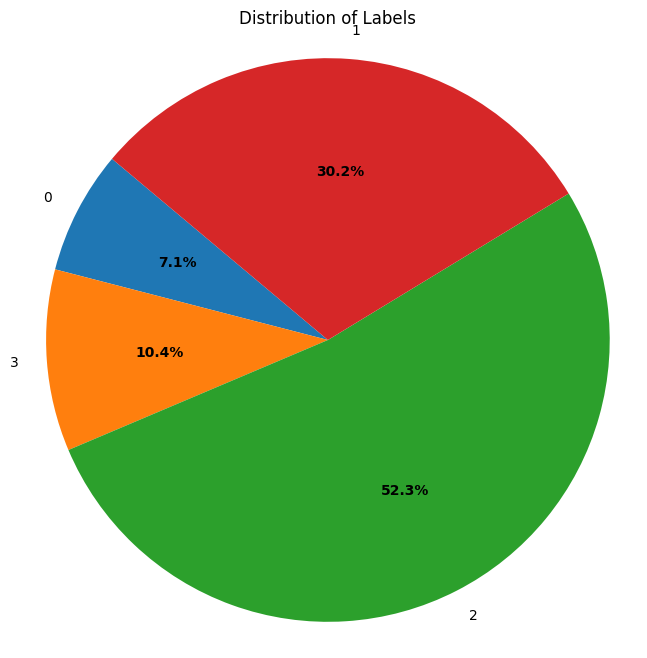

In [27]:
print(len(train_data))
labels_count = {}
for key in full_data:
    label = full_data[key]['label']
    if label in labels_count:
        labels_count[label] += 1
    else:
        labels_count[label] = 1

labels = list(labels_count.keys())
sizes = list(labels_count.values())

explode_index = 0  # Change this to the index of the class you want to stand out
explode = [0.1 if i == explode_index else 0 for i in range(len(labels))]

plt.figure(figsize=(8, 8))
_, _, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

for autotext in autotexts:
    autotext.set(weight='bold', size=10)  # Set the size and weight of all labels to bold

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Labels')
plt.show()

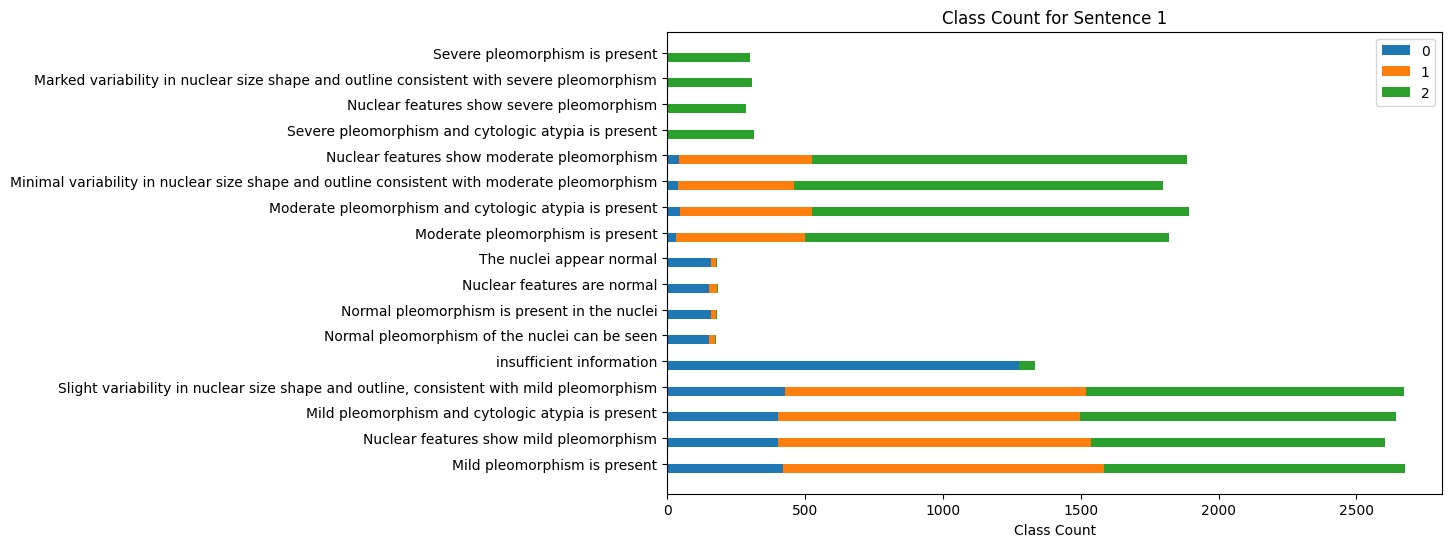

'\n\n0 is normal 1485\n1 is low grade  3690\n2 is High Grade 5205 total\n3 is insufficient info 1440\n\nmild pleomorphism is present .\n\nnuclei are crowded to a mild degree .\npolarity is completely lost . Mainly Class 2\nmitosis is rare . All are a lot\nthe nucleoli are mostly inconspicuous . \n\n\n'

In [28]:
plot_spread(check_data_spread(full_data,0),0)
# print(check_data_spread(full_data,1).keys())
'''

0 is normal 1485
1 is low grade  3690
2 is High Grade 5205 total
3 is insufficient info 1440

mild pleomorphism is present .

nuclei are crowded to a mild degree .
polarity is completely lost . Mainly Class 2
mitosis is rare . All are a lot
the nucleoli are mostly inconspicuous . 


'''

In [29]:
'''
Sentence 0 Pleomorphism:
Severe \ Modereate \ Normal \ Mild

Sentence 1 Nuclei:
No signs\ Normal \ Mild \ Severe \ Moderate

Sentence 2: POLARITY
Normal \ Not lost \ Negligibly Lost \ some degree \ Not completely lost\ is completely lost\partially lost

Sentence 3: Mitosis
Rare,Frequent(Frequently), Infrequent

Sentence 4 Nucleoli:
Incospicuous, rare, Prominent

[a,b,c,d,e]
'''
key_words_name = ["pleomorphism",["nuclei","nuclear","degree of crowding"],"polarity",["mitosis","mitotic"],"nucleoli"]
key_words = [
     
    ['severe','moderate','normal','mild'], #Sentence 0 Pleomorphism
    
    [['no signs','no nuclear crowding'],['normal','normally'],'mild','severe',['moderate','moderately']], #Sentence 1 Nuclei
    
    ['normal',['not lost','negligibly lost','no loss'], # Sentence 2: POLARITY
     ['is completely lost','complete lack of','lack of cellular polarity'],
     ['some degree','not completely lost','partially lost']],
    
    ['rare',['are frequently','is frequent','are frequent'],'infrequent'], # Sentence 3: Mitosis
    
    ['inconspicuous',['are prominent','prominent nucleoi','is prominent'],'rare'], # Sentence 4 Nucleoli
]

# 1_00073_sub0_021, N9_01_7 116704_001
#key_word_dicts = [{word: 0 for word in sublist} | {'other': 0} for sublist in key_words]
key_word_dicts= [[0]*(len(sublist)+1) for sublist in key_words]
# Print the list of dictionaries
print(key_word_dicts)
# print(train_data.keys())


[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]


In [30]:
# i = random.randint(0,4)
print(len(train_data)*5)
num_data = 0
k = 0
for key,value in train_data.items():
    captions = value['caption']
    num_data += 1
    for i in range(0,5):
        # print(i)
        # print(caption)
        # print("----------------")
        caption = captions[i]
        caption = caption.lower().rstrip('.').replace(',','').split('. ')[:-1]
        k+= 1
        for index,value in enumerate(caption):
            found_key_word = False
            #print(f"for index: {index} kw is {key_words[index]}")
            for key_idx,key_word in enumerate(key_words[index]):
                # the key word might be a list
                
                if isinstance(key_word,str):

                    if key_word in value:
                        key_word_dicts[index][key_idx] += 1
                        found_key_word = True
                else:
                    # it is a list
                    for i in key_word:
                        if i in value:
                            key_word_dicts[index][key_idx] += 1
                            found_key_word = True
                            break
            if not found_key_word:
                key_word_dicts[index][-1] += 1
# key_word_dicts[3]
# key_word_dicts[4]['prominent'] -= key_word_dicts[4]['rare']
print(k)
print(num_data)
print(key_words[3])
print(key_word_dicts)

11820
11820
2364
['rare', ['are frequently', 'is frequent', 'are frequent'], 'infrequent']
[[685, 3870, 675, 5630, 960], [820, 1265, 4395, 610, 3550, 1180], [590, 2165, 3400, 2011, 3654], [7725, 1235, 1620, 1240], [5584, 2667, 1896, 1673]]


In [31]:
total_weight = []
for index,value in enumerate(key_word_dicts):
    # print(value)
    total = 0
    for idx,count in enumerate(value):
        total += count
    total_weight.append(total)
print(total_weight)

[11820, 11820, 11820, 11820, 11820]


In [32]:
key_word_weight = key_word_dicts.copy()
print(key_word_weight)
for index,value in enumerate(key_word_dicts):
    
    for count_idx, count in enumerate(value):
        weight = round(total_weight[index]/(count * len(value)),2)
        key_word_weight[index][count_idx] = weight
print(key_word_weight)
# list(key_word_weight[0])
print(" \n")
for key,value in enumerate(key_word_weight):
    print(f"for sentence {key}, weight: {value}")

[[685, 3870, 675, 5630, 960], [820, 1265, 4395, 610, 3550, 1180], [590, 2165, 3400, 2011, 3654], [7725, 1235, 1620, 1240], [5584, 2667, 1896, 1673]]
[[3.45, 0.61, 3.5, 0.42, 2.46], [2.4, 1.56, 0.45, 3.23, 0.55, 1.67], [4.01, 1.09, 0.7, 1.18, 0.65], [0.38, 2.39, 1.82, 2.38], [0.53, 1.11, 1.56, 1.77]]
 

for sentence 0, weight: [3.45, 0.61, 3.5, 0.42, 2.46]
for sentence 1, weight: [2.4, 1.56, 0.45, 3.23, 0.55, 1.67]
for sentence 2, weight: [4.01, 1.09, 0.7, 1.18, 0.65]
for sentence 3, weight: [0.38, 2.39, 1.82, 2.38]
for sentence 4, weight: [0.53, 1.11, 1.56, 1.77]


In [33]:
print(key_word_weight)
print(type(key_word_weight))

[[3.45, 0.61, 3.5, 0.42, 2.46], [2.4, 1.56, 0.45, 3.23, 0.55, 1.67], [4.01, 1.09, 0.7, 1.18, 0.65], [0.38, 2.39, 1.82, 2.38], [0.53, 1.11, 1.56, 1.77]]
<class 'list'>


#### Trial to get the data and key word label

In [34]:
import torch.nn.functional as F
key_idx_list = []
caption = train_data['N2_07_3']['caption'][0]
caption = caption.rstrip('.').replace(',','').split('. ')[:-1]
#print(caption)
for index,value in enumerate(caption):

    found_key_word = False
    for key_idx,key_word in enumerate(key_words[index]):
        
        if isinstance(key_word,str):
            if key_word in value:

                key_idx_list.append(key_idx)
                found_key_word = True
        else:
            for i in key_word:
                if i in value:
                    key_idx_list.append(key_idx)
                    found_key_word = True
                    break

    if not found_key_word:
        key_idx_list.append(len(key_words[index]))


key_idx_list2 = []
caption = train_data['N2_07_1']['caption'][0]
caption = caption.rstrip('.').replace(',','').split('. ')[:-1]
for index,value in enumerate(caption):

    found_key_word = False
    for key_idx,key_word in enumerate(key_words[index]):
        if isinstance(key_word,str):
            if key_word in value:
                #print(f"key_word: {key_word} in {index}: class is {key_idx}")
                
                key_idx_list2.append(key_idx)
                found_key_word = True
        else:
            for i in key_word:
                if i in value:
                    key_idx_list2.append(key_idx)
                    found_key_word = True
                    break
    if not found_key_word:
        key_idx_list2.append(len(key_words[index]))
print(caption)
key_idx_tensor = torch.tensor(key_idx_list)
key_idx_tensor2 = torch.tensor(key_idx_list2) 

print(key_idx_tensor)

print(key_idx_tensor2)


#criterion = nn.CrossEntropyLoss(weight = weights,reduction = "mean")
loss = 0
for idx,value in enumerate(key_idx_tensor):
    #print(f"For idx: {idx}: tensor one {key_idx_tensor[idx]} second {key_idx_tensor2[idx]}")
    # loss += criterion(key_idx_tensor[idx],key_idx_tensor2[idx])
    pred = F.one_hot(key_idx_tensor[idx],len(key_words[idx])+1).float().view(1,-1)
    target = torch.tensor([torch.tensor(key_idx_tensor2[idx])])
    #target = F.one_hot(torch.tensor(key_idx_tensor2[idx]),len(key_words[idx])+1).float().view(1,-1)
    # print(f"    pred {pred} target {target}")
    weights = torch.FloatTensor(list(key_word_weight[idx]))
    print(f"pred shape is {pred} target is {target}")
    print(f"weights are {weights} ")
    
    loss += nn.CrossEntropyLoss(weight = weights,reduction = "mean")(pred,target)

    print(f"loss is {nn.CrossEntropyLoss(weight = weights,reduction = 'mean')(pred,target)} raw loss is { nn.CrossEntropyLoss()(pred,target)}")
print(loss)
'''

tensor [a,b,c,d,e]
'''

['insufficient information', 'insufficient information', 'insufficient information', 'insufficient information', 'insufficient information']
tensor([3, 1, 3, 0, 2])
tensor([4, 5, 4, 3, 3])
pred shape is tensor([[0., 0., 0., 1., 0.]]) target is tensor([4])
weights are tensor([3.4500, 0.6100, 3.5000, 0.4200, 2.4600]) 
loss is 1.904832363128662 raw loss is 1.9048324823379517
pred shape is tensor([[0., 1., 0., 0., 0., 0.]]) target is tensor([5])
weights are tensor([2.4000, 1.5600, 0.4500, 3.2300, 0.5500, 1.6700]) 
loss is 2.0435917377471924 raw loss is 2.0435917377471924
pred shape is tensor([[0., 0., 0., 1., 0.]]) target is tensor([4])
weights are tensor([4.0100, 1.0900, 0.7000, 1.1800, 0.6500]) 
loss is 1.9048324823379517 raw loss is 1.9048324823379517
pred shape is tensor([[1., 0., 0., 0.]]) target is tensor([3])
weights are tensor([0.3800, 2.3900, 1.8200, 2.3800]) 
loss is 1.7436684370040894 raw loss is 1.7436683177947998
pred shape is tensor([[0., 0., 1., 0.]]) target is tensor([3])
w

/scratch/pbs.5202723.kman.restech.unsw.edu.au/ipykernel_998199/2711492456.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor([torch.tensor(key_idx_tensor2[idx])])


'\n\ntensor [a,b,c,d,e]\n'

In [35]:
def embed2sentence(decode_output, loader, captions, pred_dict, cap_dict,phase):
    for i,caption in enumerate(captions):
        # print(caption)
        # print("----")
        if phase == "train":
            pass
            captions[i]= ' '.join(caption.split()).replace("<pad>", "").replace("<end>", ".").replace("<start>","").replace('<unk>',"")
        else:
            for i,caption in enumerate(captions):
                for sent_i,sent_cap in enumerate(caption):
                    captions[i][sent_i] = ' '.join(sent_cap.split()).replace("<pad>", "").replace("<end>", ".").replace("<start>","").replace('<unk>',"")

    j = 0
    for idx,embed in enumerate(decode_output):

        sentence = " ".join([loader.dataset.vocab.idx2word[int(idx)] for idx in embed])
        sentence = sentence.replace("<pad>","").replace("<start>","")
        sentence = ' '.join(sentence.split()).replace("<end>", ".")
        #print(f"length pred_dict {len(pred_dict.keys())} and length cap {len(cap_dict.keys())}")
        if len(pred_dict.keys()) == 0:
            #   Empty
            pred_dict["1"] = [sentence]
            #print(f"at 0, sentence is {sentence} decode is {embed}")
            # for i in range(5):
            #     cap_dict[str(int(i)+1)] = captions[idx]
            cap_dict["1"] = captions[idx]

            pass
        else:
            pred_dict[str(len(pred_dict)+1)] = [sentence]
            cap_dict[str(len(cap_dict)+1)] = captions[idx]
    
    return pred_dict,cap_dict

In [36]:
import torch
import torch.nn as nn
inputs = torch.FloatTensor([0,1,0,0,0,1])
outputs = torch.LongTensor([0,1])
inputs = inputs.view((1,3,2))
outputs = outputs.view((1,2))
print(f"inputs shape {inputs} outputs shape {outputs}")
weight_CE = torch.FloatTensor([1,3,9])
print(nn.CrossEntropyLoss()(inputs,outputs))
ce = nn.CrossEntropyLoss(ignore_index=255,weight=weight_CE)
loss = ce(inputs,outputs)
print(loss)

inputs shape tensor([[[0., 1.],
         [0., 0.],
         [0., 1.]]]) outputs shape tensor([[0, 1]])
tensor(1.4803)
tensor(1.6711)


In [37]:
import torch
import torch.nn as nn
from torch.autograd import Variable

output = Variable(torch.FloatTensor([0,0,0,1])).view(1, -1)
target = Variable(torch.LongTensor([3]))
print(output)
print(target)
criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
print(loss)

tensor([[0., 0., 0., 1.]])
tensor([3])
tensor(0.7437)


In [38]:
def find_key(key_words,sent):
    for key_idx,key_word in enumerate(key_words):
        if isinstance(key_word,str):
            if key_word in sent:
                return key_idx
        else:
            for i in key_word:
                if i in sent:
                    return key_idx

    if not found_key_word:
        return key_idx
def get_all_pred_label(sentence_dict,key_words_name,key_words):
    return_list = []
    for sent in sentence_dict.values():
        return_list.append(get_single_pred_sentence_label(sent[0],key_words_name,key_words))
    return torch.stack(return_list)


def get_single_pred_sentence_label(sentence,key_words_name,key_words):
    sentence_split = sentence.split('.')

    predict_sent_label = [-1,-1,-1,-1,-1]

    for sent in sentence_split:
        found = False
        for key_idx,key_name in enumerate(key_words_name):

            if isinstance(key_name,str):
                if key_name in sent:

                    predict_sent_label[key_idx] = find_key(key_words[key_idx],sent)
                    found = True
            else:
                for i in key_name:
                    if i in sent:
                        predict_sent_label[key_idx] = find_key(key_words[key_idx],sent)
                        found = True
    find_sent_label = torch.tensor([len(key_words[i]) if v == -1 else v for i,v in enumerate(predict_sent_label) ])
    return find_sent_label

In [2]:
!ls ../../../../../../srv/scratch/bic/peter/model_save/*Decoder-14*.pt | xargs -n 1 basename

Decoder-13-100-2.98.pt
Decoder-13-110-2.80.pt
Decoder-13-112-2.79.pt
Decoder-13-120-2.82.pt
Decoder-13-130-2.83.pt
Decoder-13-199-2.86.pt
Decoder-13-50-3.53.pt
Decoder-13-60-3.48.pt
Decoder-13-70-3.47.pt
Decoder-13-80-3.44.pt
Decoder-13-90-3.18.pt


In [40]:
def check_full(class_count,max_num,label):
    if class_count[str(label)] < max_num:
        return False
    else:
        return True
    # for key,value in class_count.items():
    #     if value < max_num:
    #         return True
    # return False
def check_all_full(class_count,max_num):
    for key,value in class_count.items():
        if value < max_num:
            return False
    return True

In [2]:
import torch
'''
Do the ones without weight decay first
'''
model_base_path = "../../../../../../srv/scratch/bic/peter/model_save"
encoder_name  = "Encoder-30-5-0.33.pt"
global_extractor_name = "GlobalExtractor-30-5-0.33.pt"
decoder_name = "Decoder-30-5-0.33.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder, global_feature_extractor, decoder = get_all_models(model_base_path,encoder_name, global_extractor_name,decoder_name,device)
encoder.eval()
global_feature_extractor.eval()
decoder.eval()

cuda


NameError: name 'get_all_models' is not defined

In [56]:
import torch
from sent_utils import embed2sentence
caption_criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
torch.device("cuda" if torch.cuda.is_available() else "cpu")
phase = "train"
vocab_size = len(vocabs)
dl,dataset = make_dataloader(
    batch_size = 16,
    split = phase,
    base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
    graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
    vocab_path = "new_vocab_bladderreport.pkl",
    shuffle=True,
    num_workers=0,
    load_in_ram = True
)
print(len(dl))
pred_dict = {}
cap_dict = {}
class_count = {
    "0":0,
    "1":0,
    "2":0,
}

for batch_idx, batch_data in enumerate(dl):
    pred_dict = {}
    cap_dict = {}
    cg, tg, assign_mat, caption_tokens, labels, caption, images, att_mask, idx_list= batch_data
    cg = cg.to( device)
    tg = tg.to(device)
    images =  images.to(device)
    labels = labels.to(device)
    caption_tokens = caption_tokens.to(device)
    # print(str(labels.item()))
    #class_count[str(labels.item())] += 1
    out = encoder(cg,tg,assign_mat,images)
    global_feat = global_feature_extractor(images)
    # merged_feat = torch.cat((out, global_feat), dim=1)
    # #merged_feat = out
    merged_feat = global_feat
    lstm_out, lstm_out_tensor = decoder.predict(merged_feat,80)
    '''
    for cap_idx in range(caption_tokens.size(1)):

        eval_cap_loss = caption_criterion(lstm_out_tensor.view(-1, vocab_size),caption_tokens[:,cap_idx,:].reshape(-1))
        #print(f"shape os {lstm_out_tensor.view(-1, vocab_size).shape} cap tok {caption_tokens[:,cap_idx,:].reshape(-1).shape} loss {eval_cap_loss.item()}")
    '''
    # break
    # if count == 2:
    #         break
    # count += 1   
    # print(pred_dict)
    pred_dict,cap_dict = embed2sentence(lstm_out,dl,caption,pred_dict,cap_dict,phase)
    # if check_all_full(class_count,4):
    #     break
    # if not check_full(class_count,4,labels.item()):
    #         #     for i,v in enumerate(caption):
    #     print(f"LABEL: {str(labels.item())}")
    #     print(pred_dict['1'])
    #     print(cap_dict['1'][0])
    #     # print(f"{v[0]}")
    #     print("-------------------------------------------------")


    # else:
    #     continue
    break



['../../../../../../srv/scratch/bic/peter/full-graph/cell_graphs/train/115833_000.bin', '../../../../../../srv/scratch/bic/peter/full-graph/cell_graphs/train/115833_001.bin']
length report 2336
146


TypeError: iteration over a 0-d tensor

In [54]:
model_base_path = "../../../../../../srv/scratch/bic/peter/model_save"
encoder_name  = "Encoder-12-103-2.76.pt"
global_extractor_name = "GlobalExtractor-12-103-2.76.pt"
decoder_name = "Decoder-12-103-2.76.pt"
sent_dict = get_predicted_spread(model_base_path,
    encoder_name,
    global_extractor_name,
    decoder_name,
    "test",
    test_data.keys(),
    0)

encoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Encoder-12-103-2.76.pt
global exsists at ../../../../../../srv/scratch/bic/peter/model_save/GlobalExtractor-12-103-2.76.pt
decoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Decoder-12-103-2.76.pt


In [55]:
t1 = lstm_out_tensor.view(2, 80, 115)
t2 = caption_tokens[:,0,:].reshape(-1)
#print(lstm_out_tensor[0][6])
print(lstm_out_tensor[0].shape)
loss = F.cross_entropy(t1.view(-1, 115), t2.view(-1))
#print(t2)
print(f"t1 v {t1.view(-1, 115).shape} t2 {t2.view(-1).shape} loss {loss}")
l = 0
for i in range(116):
    l += F.cross_entropy(t1.view(-1, 115)[i], t2.view(-1)[i])
print(l/116)

RuntimeError: shape '[2, 80, 115]' is invalid for input of size 147200

In [ ]:

#predict_sent_label = get_all_pred_label(pred_dict,key_words_name,key_words) # eval
predict_sent_label = get_all_pred_label(pred_dict,key_words_name,key_words)# train

print(predict_sent_label.shape)
print(idx_list.shape)
# print(find_sent_label.shape)

# for i in range(idx_list.size(1)):
#     print(idx_list[:,i,:].shape)

In [ ]:
# calculating loss, two situations.
first_pred_lab = predict_sent_label
first_gt_lab = idx_list
# print(first_pred_lab)
# print("---------")
# first_gt_lab = first_pred_lab.unsqueeze(1).expand(-1, 5, -1)
# print(first_gt_lab)
def get_single_sent_label_loss(pred,gt,key_words,key_word_weight):
    '''
    pred ([1,5])
    gt ([5])
    '''
    loss = 0

    for idx,value in enumerate(pred):
 
        pred = F.one_hot(value,len(key_words[idx])+1).float().view(1,-1)
        target = torch.tensor([torch.tensor(gt[idx])])
        weights = torch.FloatTensor(list(key_word_weight[idx]))
        #print(f"pred is {pred} tar is {target}")
        loss += nn.CrossEntropyLoss(weight = weights,reduction = "mean")(pred,target)
    return loss/5


def get_eval_sent_label_loss(pred,gt,key_word,key_word_weight):
    loss_list = []
    for idx in range(5):
        loss_list.append(get_single_sent_label_loss(pred,gt[idx],key_word,key_word_weight))
    return np.mean(loss_list)

def get_batch_sent_label_loss(pred,gt,key_words,key_word_weight,phase):
    # train, and eval/test have different strategies
    bs = pred.shape[0]
    loss_list = []
    #print()
    #print(f"pred len {pred.shape} and len gt {gt.shape} bs is {bs}")
    for idx in range(bs):
        #print(idx)
        if phase == "train":
            loss_list.append(get_single_sent_label_loss(pred[idx],gt[idx],key_words,key_word_weight))
        else:
            loss_list.append(get_eval_sent_label_loss(pred[idx],gt[idx],key_words,key_word_weight))
        
    return np.mean(loss_list)


loss = get_batch_sent_label_loss(first_pred_lab,first_gt_lab,key_words,key_word_weight,phase = "eval")
print(loss)

In [ ]:
print_predict(sent_dict)

In [ ]:
ten1 = torch.tensor([[3,2,2,0,0],[3,2,2,0,0]])
ten2 = torch.tensor([[[3, 2, 2, 0, 0],
                     [3, 2, 2, 0, 0],
                     [3, 2, 2, 0, 0],
                     [3, 2, 2, 0, 0],
                     [3, 2, 2, 0, 0]],
        [[3, 2, 2, 0, 0],
         [3, 2, 2, 0, 0],
         [3, 2, 2, 0, 0],
         [3, 2, 2, 0, 0],
         [3, 2, 2, 0, 0]]])
get_batch_sent_label_loss(ten1,ten2,key_words,key_word_weight,phase = "eval")

In [ ]:
sent_dict

In [7]:
train_dl,_ = make_dataloader(
        batch_size =2, # there are 1000 set 1 because we will calculate pair by pair
        split = "train",
        base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
        graph_path = "../../../../../../srv/scratch/bic/peter/full-graph-raw",
        vocab_path = "new_vocab_bladderreport.pkl",
        shuffle=True,
        num_workers=0,
        load_in_ram = True,
        mode = "eval"
    )

Base data path ../../../../../../srv/scratch/bic/peter/Report
cg path is ../../../../../../srv/scratch/bic/peter/full-graph-raw/cell_graphs/train
num cg 2336 cell graph len2336
['../../../../../../srv/scratch/bic/peter/full-graph-raw/cell_graphs/train/115833_000.bin', '../../../../../../srv/scratch/bic/peter/full-graph-raw/cell_graphs/train/115833_001.bin']


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_name  = "Encoder-51-60-2.92.pt"
global_extractor_name = "GlobalExtractor-51-60-2.92.pt"
decoder_name = "Decoder-51-60-2.92.pt"
model_base_path = "../../../../../../srv/scratch/bic/peter/model_save"
# device = "cpu"
encoder, global_feature_extractor, decoder =  get_all_models(model_base_path,encoder_name,global_extractor_name,decoder_name,device)
print(decoder)

encoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Encoder-51-60-2.92.pt
global exsists at ../../../../../../srv/scratch/bic/peter/model_save/GlobalExtractor-51-60-2.92.pt
decoder exists at ../../../../../../srv/scratch/bic/peter/model_save/Decoder-51-60-2.92.pt
LSTMDecoder(
  (dropout): Dropout(p=0.5, inplace=False)
  (word_embedding): Embedding(117, 512)
  (lstm): LSTM(512, 256, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=256, out_features=117, bias=True)
  (init_h): Linear(in_features=512, out_features=256, bias=True)
  (init_c): Linear(in_features=512, out_features=256, bias=True)
)


In [8]:
cg, tg, assign_mat, caption_tokens, labels, captions, images,_,_ = next(iter(train_dl))
cg = cg.to( device)
tg = tg.to(device)
images =  images.to(device)
caption_tokens = caption_tokens.to(device)

In [9]:
out = encoder(cg,tg,assign_mat,images)
#print(f"encoder out shape {out.shape}")
global_feat = global_feature_extractor(images)
#merged_feat = out
merged_feat = torch.cat((out, global_feat), dim=1)
#print(f"g feat get")
#merged_feat = global_feat
#print(f"merged feat {merged_feat}")
lstm_out, lstm_out_tensor = decoder.predict(merged_feat,80)

tensor([[-0.8857,  0.6121,  1.0809,  ...,  0.2396, -0.3910, -0.5939],
        [ 0.9597, -0.6074, -1.1791,  ..., -0.2551,  0.1907,  0.0666]],
       device='cuda:0', grad_fn=<CatBackward0>)


In [20]:
decode_output = lstm_out
for idx,embed in enumerate(decode_output):

    sentence = " ".join([train_dl.dataset.vocab.idx2word[int(idx)] for idx in embed])
    # print(sentence)
    sentence = sentence.replace("<pad>","").replace("<start>","")
    #sentence = ' '.join(sentence.split()).replace("<end>", "").replace("<full-stop>",".")
    #sentence = sentence.strip().replace("<full-stop>", ".")
    sentence = ' '.join(sentence.split()).replace("<end>", "").strip()
    sentence = ' '.join(sentence.split()).replace(" <full-stop>", ".")
    
    sentences = [s.strip().capitalize() for s in sentence.split('.')]
    sentence = '. '.join(sentences).rstrip('.')

    print(sentence)

Pleomorphism is present. There is present. The nuclei are crowded to degree. Polarity is lost. Mitosis is rare. The nucleoli are to inconspicuous. 
Nuclear size shape and outline consistent with pleomorphism. There is present. There is a degree of polarity. The nuclei are crowded to be. Mitosis is rare. The nucleoli are prominent. 
